<a href="https://colab.research.google.com/github/AlexKaiqi/Machine-Learning/blob/master/notebook/agentchat_auto_feedback_from_code_execution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/microsoft/autogen/blob/main/notebook/agentchat_auto_feedback_from_code_execution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

将大语言模型的工作流拆分成独立的、可控的、可调试的小的功能单元，以Agent的形式存在，Agent与Agent之间的基于对话的交流，完成自动化的，基于大语言模型工作流的执行。

autogen多个agent>=3，并且允许期间用户可参与。

# Auto Generated Agent Chat: Task Solving with Code Generation, Execution & Debugging

AutoGen offers conversable LLM agents, which can be used to solve various tasks with human or automatic feedback, including tasks that require using tools via code.
Please find documentation about this feature [here](https://microsoft.github.io/autogen/docs/Use-Cases/agent_chat).

In this notebook, we demonstrate how to use `AssistantAgent` and `UserProxyAgent` to write code and execute the code. Here `AssistantAgent` is an LLM-based agent that can write Python code (in a Python coding block) for a user to execute for a given task. `UserProxyAgent` is an agent which serves as a proxy for the human user to execute the code written by `AssistantAgent`, or automatically execute the code. Depending on the setting of `human_input_mode` and `max_consecutive_auto_reply`, the `UserProxyAgent` either solicits feedback from the human user or returns auto-feedback based on the result of code execution (success or failure and corresponding outputs) to `AssistantAgent`. `AssistantAgent` will debug the code and suggest new code if the result contains error. The two agents keep communicating to each other until the task is done.

## Requirements

AutoGen requires `Python>=3.8`. To run this notebook example, please install:
```bash
pip install pyautogen
```

In [46]:
%pip install pyautogen

## Set your API Endpoint

The [`config_list_from_json`](https://microsoft.github.io/autogen/docs/reference/oai/openai_utils#config_list_from_json) function loads a list of configurations from an environment variable or a json file.


In [55]:
import autogen
config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4", "gpt-4-0314", "gpt4", "gpt-4-32k", "gpt-4-32k-0314", "gpt-4-32k-v0314", "gpt-3.5-turbo"],
    },
)

It first looks for environment variable "OAI_CONFIG_LIST" which needs to be a valid json string. If that variable is not found, it then looks for a json file named "OAI_CONFIG_LIST". It filters the configs by models (you can filter by other keys as well). Only the gpt-4 models are kept in the list based on the filter condition.

The config list looks like the following:
```python
config_list = [
    {
        'model': 'gpt-4',
        'api_key': '<your OpenAI API key here>',
    },
    {
        'model': 'gpt-4',
        'api_key': '<your Azure OpenAI API key here>',
        'base_url': '<your Azure OpenAI API base here>',
        'api_type': 'azure',
        'api_version': '2023-06-01-preview',
    },
    {
        'model': 'gpt-4-32k',
        'api_key': '<your Azure OpenAI API key here>',
        'base_url': '<your Azure OpenAI API base here>',
        'api_type': 'azure',
        'api_version': '2023-06-01-preview',
    },
]
```

You can set the value of config_list in any way you prefer. Please refer to this [notebook](https://github.com/microsoft/autogen/blob/main/notebook/oai_openai_utils.ipynb) for full code examples of the different methods.

## Example Task: Check Stock Price Change

In the example below, let's see how to use the agents in AutoGen to write a python script and execute the script. This process involves constructing a `AssistantAgent` to serve as the assistant, along with a `UserProxyAgent` that acts as a proxy for the human user. In this example demonstrated below, when constructing the `UserProxyAgent`,  we select the `human_input_mode` to "NEVER". This means that the `UserProxyAgent` will not solicit feedback from the human user. It stops replying when the limit defined by `max_consecutive_auto_reply` is reached, or when `is_termination_msg()` returns true for the received message.

In [56]:
# create an AssistantAgent named "assistant"
assistant = autogen.AssistantAgent(
    name="assistant",
    llm_config={
        "cache_seed": 42,  # seed for caching and reproducibility
        "config_list": config_list,  # a list of OpenAI API configurations
        "temperature": 0,  # temperature for sampling
    },  # configuration for autogen's enhanced inference API which is compatible with OpenAI API
)
# create a UserProxyAgent instance named "user_proxy"
user_proxy = autogen.UserProxyAgent(
    name="user_proxy",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE"),
    code_execution_config={
        "work_dir": "coding",
        "use_docker": False,  # set to True or image name like "python:3" to use docker
    },
)
# the assistant receives a message from the user_proxy, which contains the task description
user_proxy.initiate_chat(
    assistant,
    message="""What date is today? Compare the year-to-date gain for META and TESLA.""",
)

user_proxy (to assistant):

What date is today? Compare the year-to-date gain for META and TESLA.

--------------------------------------------------------------------------------
assistant (to user_proxy):

First, let's get the current date. We can do this using Python's built-in datetime module. Here is the Python code to get the current date:

```python
import datetime

# Get the current date
current_date = datetime.date.today()

print("Today's date is:", current_date)
```

Next, we need to get the year-to-date (YTD) gain for META (Facebook) and TESLA. We can do this by using a financial data API such as Yahoo Finance or Alpha Vantage. However, these APIs require an API key which is usually personal and not shared. Therefore, I can't provide a complete code for this part. 

However, I can guide you on how to do it:

1. Register and get an API key from a financial data provider such as Yahoo Finance or Alpha Vantage.
2. Use the API key to make a request to the API and get the stock p

The example above involves code execution. In AutoGen, code execution is triggered automatically by the `UserProxyAgent` when it detects an executable code block in a received message and no human user input is provided. This process occurs in a designated working directory, using a Docker container by default. Unless a specific directory is specified, AutoGen defaults to the `autogen/extensions` directory. Users have the option to specify a different working directory by setting the `work_dir` argument when constructing a new instance of the `UserProxyAgent`.

The whole chat is auto-generated.

## Example Task: Plot Chart

In [57]:
# followup of the previous question
user_proxy.send(
    recipient=assistant,
    message="""Plot a chart of their stock price change YTD and save to stock_price_ytd.png.""",
)

user_proxy (to assistant):

Plot a chart of their stock price change YTD and save to stock_price_ytd.png.

--------------------------------------------------------------------------------
assistant (to user_proxy):

To plot a chart of the stock price change year-to-date (YTD) for META and TESLA, we can use the matplotlib library in Python. If you haven't installed it yet, you can do so using pip:

```shell
pip install matplotlib
```

Then, you can use the following Python script to plot the chart and save it to a file:

```python
import matplotlib.pyplot as plt

# Plot the closing prices of META and TESLA
plt.figure(figsize=(14, 7))
plt.plot(meta_data['Close'], label='META')
plt.plot(tesla_data['Close'], label='TESLA')

# Add title and labels
plt.title('META vs TESLA Stock Price YTD')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')

# Add a legend
plt.legend()

# Save the plot to a file
plt.savefig('stock_price_ytd.png')

print("The plot has been saved as 'stock_price_ytd.png'.")


Let's display the generated figure.

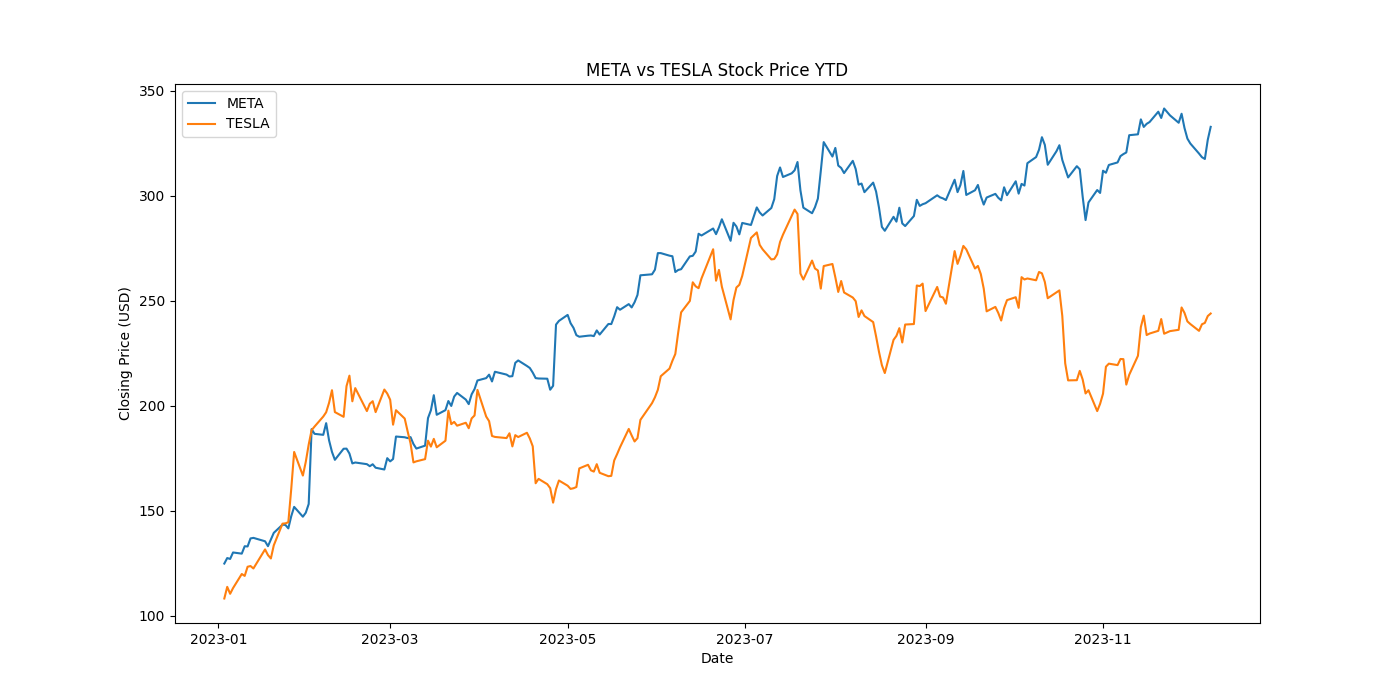

In [58]:
from IPython.display import Image

Image(filename='coding/stock_price_ytd.png')

## Use a Different Code Execution Environment

The code execution happened in a separate process, so the plot is not directly displayed in the notebook. Is it possible to change the code execution environment into IPython?

Yes! In the following we demonstrate how to extend the `UserProxyAgent` to use a different code execution environment.

In [59]:
from typing import Dict, Union
from IPython import get_ipython

class IPythonUserProxyAgent(autogen.UserProxyAgent):
    def __init__(self, name: str, **kwargs):
        super().__init__(name, **kwargs)
        self._ipython = get_ipython()

    def generate_init_message(self, *args, **kwargs) -> Union[str, Dict]:
        return super().generate_init_message(*args, **kwargs) + """
If you suggest code, the code will be executed in IPython."""

    def run_code(self, code, **kwargs):
        result = self._ipython.run_cell("%%capture --no-display cap\n" + code)
        log = self._ipython.ev("cap.stdout")
        log += self._ipython.ev("cap.stderr")
        if result.result is not None:
            log += str(result.result)
        exitcode = 0 if result.success else 1
        if result.error_before_exec is not None:
            log += f"\n{result.error_before_exec}"
            exitcode = 1
        if result.error_in_exec is not None:
            log += f"\n{result.error_in_exec}"
            exitcode = 1
        return exitcode, log, None

The implementation overrides three functions in `UserProxyAgent`:
* constructor. We get the ipython instance as the code execution environment.
* `generate_init_message`. We generate a modified initial message to send to the assistant agent, by adding the info that the execution will be performed in IPython.
* `run_code`. We execute the code with the ipython instance.

With the new `IPythonUserProxyAgent`, we are able to run the code within the current notebook environment and display the plot directly.

In [60]:
ipy_user = IPythonUserProxyAgent(
    "ipython_user_proxy",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE") or x.get("content", "").rstrip().endswith('"TERMINATE".'),
)
# the assistant receives a message from the user, which contains the task description
ipy_user.initiate_chat(
    assistant,
    message="""Plot a chart of META and TESLA stock price gain YTD""",
)

ipython_user_proxy (to assistant):

Plot a chart of META and TESLA stock price gain YTD
If you suggest code, the code will be executed in IPython.

--------------------------------------------------------------------------------
assistant (to ipython_user_proxy):

To plot a chart of META (Facebook) and TESLA stock price gain year-to-date (YTD), we can use the `yfinance` library in Python, which allows us to download stock data from Yahoo Finance. We will also use `matplotlib` to plot the data.

Here is the Python code to do this:

```python
# Python code
import yfinance as yf
import matplotlib.pyplot as plt

# Download historical data as dataframe
meta = yf.download('FB', start='2022-01-01')
tesla = yf.download('TSLA', start='2022-01-01')

# Calculate the YTD return
meta['YTD'] = (meta['Adj Close'] / meta['Adj Close'][0]) - 1
tesla['YTD'] = (tesla['Adj Close'] / tesla['Adj Close'][0]) - 1

# Plot the YTD return
plt.figure(figsize=(14,7))
plt.plot(meta['YTD'], label='META')
plt.plot(tes

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['FB']: Exception('%ticker%: No timezone found, symbol may be delisted')


IndexError: ignored


>>>>>>>> EXECUTING CODE BLOCK 1 (inferred language is python)...
ipython_user_proxy (to assistant):

exitcode: 0 (execution succeeded)
Code output: 
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



--------------------------------------------------------------------------------
assistant (to ipython_user_proxy):

It seems like the code has been executed successfully and the required libraries are already installed. However, as I can't see the output plot, I can't verify if the chart was plotted correctly. 

If the chart was plotted correctly, it should show the YTD return for both META and TESLA from the start of the current year to the present. The YTD return is plotted on the y-axis and the date is plotted on the x-axis. There should be two lines on the chart, one for META and one for TESLA, and a legend indicating which line corresponds to which stock.

If the chart looks as described, then 

这个只是个人感兴趣的一个应用方向，个人认为这并不是最大的蛋糕。
打个比方，大模型本身是金矿，提供大模型应用服务的就是卖锄头的。
开发者只能算是挖矿的，收益与风险并存。


这样相互协作可能是好的方式，毕竟模型如果已经具备了全部的知识，肯定可以直接完成的，这样迭代成本太高了。

不过，在大模型知识还不完备的条件下，可以用这种方式将领域先验知识作为约束条件。

不过这是一个可以窥见大模型潜力的一个很好的角度。如果我们将useragent泛化一下，程序代码提供与外界信息交互的渠道，用户输入改为传感器对周围环境的感知，一个现实的ai机器人是不是就有了？

不容易优化

最核心的部分是模型，但多数场景下都没有优化模型的条件。只能通过一些特殊的fine-tunning手段。并且升级模型后，也得配套重新优化。